# Test Notebook
To test the functionality of the in situ transcriptomics analysis pipeline.

### Functionality tested: 
- parameter extraction 
- blob detection, using parameter extraction
- autocropping, using parameter extraction
- QC and reassembly of worker-annotated crops

In [1]:
from skimage.feature import blob_log
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os, warnings

In [2]:
from fishanno import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, clus, param, util, vis

In [3]:
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## User Inputs

In [4]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['cyan', 'blue', 'purple', 'violet', 'magenta', 'red', 'orange', 'yellow', 'green', ]    
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

In [5]:
img_filename = 'ISS_rnd0_ch3_z0.png'
img_path = './image/' + img_filename
expert_filename = 'ISS_rnd0_ch3_z0.csv'
expert_path = './expert/' + expert_filename

#### Sanity check: expert annotations and image line up

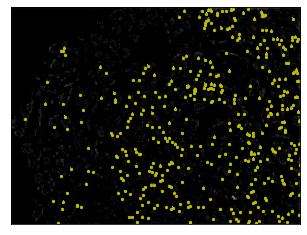

In [6]:
im = imread(img_path, as_gray=True)
ref = np.asarray(pd.read_csv(expert_path))
for x, y in ref:
    plt.scatter([x], [y], color='y', s=5)
plt.imshow(im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Test Parameter Extraction

In [7]:
if not os.path.exists('./spot_params/'):
    os.mkdir('./spot_params/')
expert_coords = np.genfromtxt(expert_path, delimiter=',')[1:]
sigma_list = param.get_sigma_list(img_path, expert_coords, margin)
np.savetxt('./spot_params/param_extraction_sigmas.csv', sigma_list, delimiter=',')

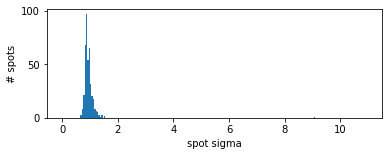

In [8]:
sigma_list = np.asarray(pd.read_csv('./spot_params/param_extraction_sigmas.csv'))
plt.figure(figsize=(6,2))
plt.hist(sigma_list, bins=np.arange(0, 11, 0.05))
plt.yticks([0, 50, 100])
plt.xlabel('spot sigma')
plt.ylabel('# spots')
plt.show()

#### Expected output:

<img src="expected_outputs/sigma_hist.png" style="width: 390px;" align="left"/>

In [9]:
# Assign a range of intensity thresholds to test.
thresholds = np.arange(0.1, 0.4, 0.03)

# Run blob detection with a range of thresholds and find the best threshold.
best_threshold, best_recall, best_precision, recall_list, precision_list = param.get_best_threshold(
    expert_coords, img_path, min(sigma_list), max(sigma_list), correctness_threshold, thresholds)

np.savetxt('./spot_params/param_extraction_precision.csv', precision_list, delimiter=',')
np.savetxt('./spot_params/param_extraction_recall.csv', recall_list, delimiter=',')

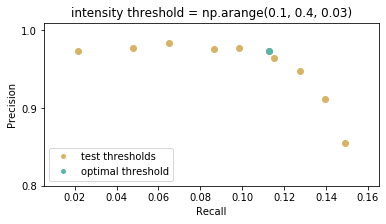

In [10]:
precision_list = np.asarray(pd.read_csv('./spot_params/param_extraction_precision.csv'))
recall_list = np.asarray(pd.read_csv('./spot_params/param_extraction_recall.csv'))
best_recall = recall_list[4]
best_precision = precision_list[4]

plt.figure(figsize = (6, 3))
plt.scatter(recall_list, precision_list, c='#d8b365')
plt.scatter([best_recall], [best_precision], c='#5ab4ac')
plt.xlabel('Recall')
plt.yticks([.8, .9, 1])
plt.ylabel('Precision')

handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
plt.legend(handles=[handle1, handle2], loc='lower left')

plt.title('intensity threshold = np.arange(0.1, 0.4, 0.03)')
plt.show()

### Expected output:

<img src="expected_outputs/find_intensity_threshold.png" style="width: 390px;" align="left"/>

## Print and save blob detection parameters
The min sigma, max sigma, and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [11]:
min_sigma = min(sigma_list)[0]
max_sigma = max(sigma_list)[0]

print('smallest spot_sigma = %f' % (round(min_sigma, 2)))
print('greatest spot_sigma = %f' % (round(max_sigma, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))
np.savetxt('./spot_params/spot_params.csv', [[min_sigma, max_sigma, best_threshold]], header='min_sigma,max_sigma,best_threshold', delimiter=",", comments='')

smallest spot_sigma = 0.680000
greatest spot_sigma = 9.070000
optimal intensity threshold = 0.130000


### Expected output:

- smallest spot_sigma = 0.68
- greatest spot_sigma = 9.07
- optimal intensity threshold =0.13

# Test Blob Detection

In [12]:
# Run blob_log() on all test images using min_sigma, max_sigma, and best_threshold found above.

blob_params = pd.read_csv('./spot_params/spot_params.csv')
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]

im = imread(img_path, as_gray=True)
img_height = len(im)

if not os.path.exists('./blobs/'):
    os.mkdir('./blobs/')

blob_path = './blobs/blobs.csv'

blobs_log = blob_log(im, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
blobs = [[c, r] for r, c, sigma in blobs_log]

np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

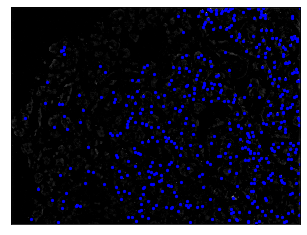

In [13]:
# Plot blobs
blobs = np.asarray(pd.read_csv(blob_path))
plt.figure()
im = imread(img_path)
plt.imshow(im, cmap='gray')
for x, y in blobs:
    plt.scatter([x], [y], color='blue', s=5)
plt.xlim(0, im.shape[1])
plt.ylim(0, im.shape[0])
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()

### Expected output:

<img src="expected_outputs/blobs.png" style="width: 305px;" align="left"/>

# Test Autocropping

In [14]:
if not os.path.exists('./crops/'):
    os.mkdir('./crops/')
img_name = 'ISS_rnd0_ch3_z0'
crop_dir = 'test_crops'
parent_dir = 'image'

blob_path = './blobs/blobs.csv'
blobs = np.asarray(pd.read_csv(blob_path))

image_width = imread(img_path).shape[1]
crosshair_arm_length = crosshair_ratio * image_width

autocrop.autocrop(blobs, img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio, crop_dir, parent_dir)

Plot crops for ISS_rnd0_ch3_z0

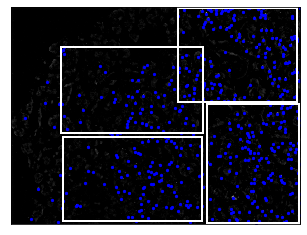

In [15]:
blob_path = './blobs/blobs.csv'
blobs = np.asarray(pd.read_csv(blob_path))

fig,ax = plt.subplots(1)
im = imread(img_path)
plt.imshow(im, cmap='gray')
for x, y in blobs:
    plt.scatter([x], [y], color='blue', s=5)
plt.xlim(0, im.shape[1])
plt.ylim(0, im.shape[0])

for j in range(4):
    csv_path = './crops/%s_%s.csv' % (img_name, j)
    crop = np.genfromtxt(csv_path, delimiter=',')
    rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor='w', facecolor='none', linewidth=2)
    ax.add_patch(rect)

plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()

### Expected output:

<img src="expected_outputs/autocrops.png" style="width: 305px;" align="left"/>

# Test QC and Reassembly

### QC, save consensus coords

In [16]:
img_filename = 'ISS_rnd0_ch3_z0'

In [17]:
crops_path = './test_crops/'
json_filepath = './anno/ISS_rnd0_ch3_z0.json'
crop_filenames = [f for f in os.listdir(crops_path) if f.endswith('.png')]

if not os.path.exists('./consensus/'):
    os.mkdir('consensus')
    
for crop_filename in crop_filenames:
    
    crop_filepath = './crops/' + crop_filename

    print('Now processing %s' % (crop_filename))

    img_filepath = './test_crops/%s' % (crop_filename)

    qa = QuantiusAnnotation(json_filepath, crop_filename)
    sa = SpotAnnotationAnalysis(qa)
    anno_all = qa.df()

    # cluster annotations
    clusters = sa.get_clusters(anno_all, clustering_params)  

    # apply QC
    cluster_size_threshold = clus.get_cluster_size_threshold(clusters)
    small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)

    clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)
    clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
    clusters_post_qc = nonclumpy_clusters

    if len(clumpy_clusters.index) is not 0:
        for i in range(len(clumpy_clusters.index)):
            subclusters = clus.declump(clumpy_clusters, i, declumping_params)
        clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

    # save consensus coords        
    im = imread(crop_filepath)
    crop_height = len(im)
    clusters_post_qc_list = []
    for index in clusters_post_qc.index:
        row = clusters_post_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_post_qc_list.append([x, crop_height-y])
    path = ('./consensus/' + crop_filename.replace('.png', '.csv'))
    np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')

Now processing ISS_rnd0_ch3_z0_blacked.png
Now processing ISS_rnd0_ch3_z0_0.png
Now processing ISS_rnd0_ch3_z0_1.png
Now processing ISS_rnd0_ch3_z0_3.png
Now processing ISS_rnd0_ch3_z0_2.png


## Reassembly of consensus coords, save reassembled coords

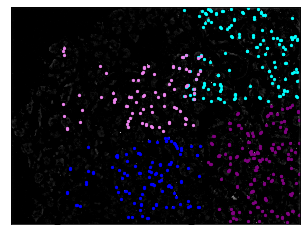

In [18]:
blacked_path = './consensus/' + img_filename + '_blacked.csv'
total = []
coords_blacked = np.asarray(pd.read_csv(blacked_path))

for coord in coords_blacked:
    plt.scatter(coord[0], coord[1], color = 'black')
    total.append([coord[0], coord[1]])

for i in range(4):
    coords_path = './consensus/' + img_filename + '_' + str(i) + '.csv'
    coords = np.asarray(pd.read_csv(coords_path))
    stats_path = './crops/' + img_filename + '_' + str(i) + '.csv'
    stats = np.asarray(pd.read_csv(stats_path, header = None))
    xmin = stats[0][0]
    ymin = stats[2][0]
    ymax = stats[3][0]
    height = ymax - ymin
    zoom_factor = stats[4][0]

    refit = []
    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = coord[1]/zoom_factor + ymin
        refit.append([x, y])
        total.append([x, y])
    refit = np.asarray(refit)

    for coord in refit:
        plt.scatter(coord[0], coord[1], color=colors[i], s=5)

im = imread(img_path, as_gray=True)
plt.imshow(im, cmap='gray')

plt.xticks([])
plt.yticks([])
np.savetxt('./consensus/total.csv', np.asarray(total), delimiter=",", comments='', header='centroid_x,centroid_y')
plt.show()

### Expected output:

<img src="expected_outputs/reassembled.png" style="width: 305px;" align="left"/>